In [28]:
from tqdm import tqdm
import random
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
from omegaconf import OmegaConf
from copy import deepcopy
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from cfgen.models.fm.fm import FM
from scvi.distributions import NegativeBinomial

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4)) 

## Initialize dataset and encoder

In [29]:
dataset_conf = OmegaConf.load("../../configs/configs_sccfm/dataset/pbmc_covid.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/default.yaml")

In [18]:
dataset_conf

{'dataset_path': '../../project_folder/datasets/processed/classifier_experiment_pbmc/pbmc_covid_train.h5ad', 'layer_key': 'X_counts', 'covariate_keys': ['cell_type'], 'subsample_frac': 1, 'normalization_type': 'log_gexp', 'one_hot_encode_features': False, 'split_rates': [0.9, 0.1], 'cov_embedding_dimensions': 100, 'is_binarized': False, 'theta_covariate': 'cell_type', 'size_factor_covariate': 'cell_type', 'guidance_weights': {'cell_type': 1}}

Initialize dataset

In [19]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        drop_last=False)

in_dim = dataset.X["rna"].shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

Initialize Autoencoder

In [20]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [21]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_pbmc_covid_final/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

## Initialize Flow Matching model

In [22]:
generative_model_config = OmegaConf.load("../../configs/configs_sccfm/generative_model/default.yaml")

In [23]:
ckpt = torch.load("../../project_folder/experiments/cfgen_ckpt/train_fm_pbmc_covid_final/last.ckpt", weights_only=False)

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [24]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.4129,  0.2577, -1.7231,  ..., -1.4078, -1.3474,  0.9413],
        [ 1.3061,  1.1968, -1.4526,  ..., -0.8954, -0.4232,  1.2813],
        [-0.0065, -0.8220, -1.7873,  ..., -0.2371, -0.5690, -1.7198],
        ...,
        [ 2.2507,  0.9020, -3.1106,  ..., -2.6643, -2.8228,  3.4719],
        [ 1.5754, -0.6386,  0.4238,  ..., -1.0472,  3.0364, -2.4790],
        [-0.8951, -0.3284, -1.0441,  ..., -0.0536, -1.2964,  1.2596]],
       device='cuda:0', requires_grad=True)


In [25]:
generative_model = FM(encoder_model=encoder_model,
                        denoising_model=denoising_model,
                        feature_embeddings=feature_embeddings,
                        plotting_folder=None,
                        in_dim={"rna": 50},
                        size_factor_statistics=size_factor_statistics,
                        covariate_list=["cell_type"],
                        theta_covariate="cell_type",
                        size_factor_covariate="cell_type",
                        is_binarized=False,
                        modality_list=["rna"],
                        guidance_weights={"cell_type": 1},
                        **generative_model_config  # model_kwargs should contain the rest of the arguments
                        )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (encoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=2000, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=256, out_features=50, bias=True)
        )
      )
    )
    (decoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=50, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (

## Load real dataset 

In [47]:
adata_original = sc.read_h5ad(dataset_conf["dataset_path"])
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.toarray().sum(1)

In [48]:
sc.pp.subsample(adata_original, 0.3)

In [49]:
adata_original 

AnnData object with n_obs × n_vars = 103446 × 2000
    obs: 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'size_factor'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'antibody_X', 'antibody_features', 'cell_type_colors',

## Generate and save cells

In [50]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B cell': np.int64(440),
 'CD16-negative, CD56-bright natural killer cell, human': np.int64(1100),
 'CD4-positive helper T cell': np.int64(9174),
 'CD4-positive, alpha-beta cytotoxic T cell': np.int64(1471),
 'CD8-positive, alpha-beta cytotoxic T cell': np.int64(9787),
 'central memory CD8-positive, alpha-beta T cell': np.int64(3261),
 'class switched memory B cell': np.int64(1005),
 'classical monocyte': np.int64(12883),
 'conventional dendritic cell': np.int64(613),
 'dendritic cell': np.int64(17),
 'effector memory CD8-positive, alpha-beta T cell': np.int64(633),
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': np.int64(1686),
 'erythrocyte': np.int64(104),
 'gamma-delta T cell': np.int64(1313),
 'granulocyte': np.int64(6),
 'hematopoietic precursor cell': np.int64(236),
 'innate lymphoid cell': np.int64(114),
 'mature NK T cell': np.int64(174),
 'mucosal invariant T cell': np.int64(996),
 'naive B cell': np.int64(11465),
 'naive thymus-derived CD4-pos

In [51]:
X_generated_list = []  # Will contain generated cells 
classes_str = []  # Will contain annotation 

# Generate in batches -- roughly 18k cells
for _ in tqdm(range(30)):
    num_indices = 1000
    index_range = len(adata_original)
    
    # Sample conditions from the data (roughly keeps the same observed proportions)
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)  
    classes_str += classes
    classes = {"cell_type": torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes])}

    log_size_factors = {"rna": torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()}
    X_generated = generative_model.batched_sample(batch_size=100,
                                                    repetitions=10,
                                                    n_sample_steps=2, 
                                                    theta_covariate="cell_type", 
                                                    size_factor_covariate="cell_type", 
                                                    conditioning_covariates=["cell_type"],
                                                    covariate_indices=classes, 
                                                    log_size_factor=log_size_factors)

    X_generated_list.append(X_generated["rna"].to("cpu"))

100%|██████████| 30/30 [02:11<00:00,  4.39s/it]


In [52]:
X_generated = torch.cat(X_generated_list, dim=0).numpy()

In [53]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [54]:
adata_merged = sc.AnnData(X=np.concatenate([adata_original.X.toarray(), X_generated], axis=0), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [55]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

In [56]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

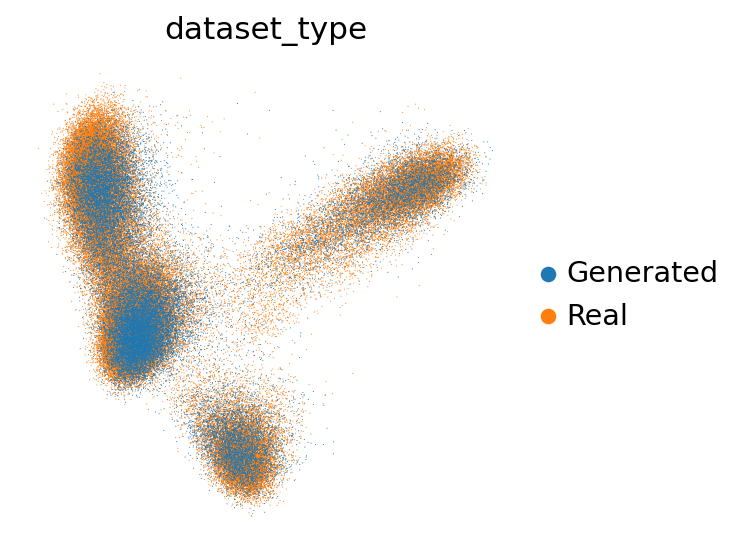

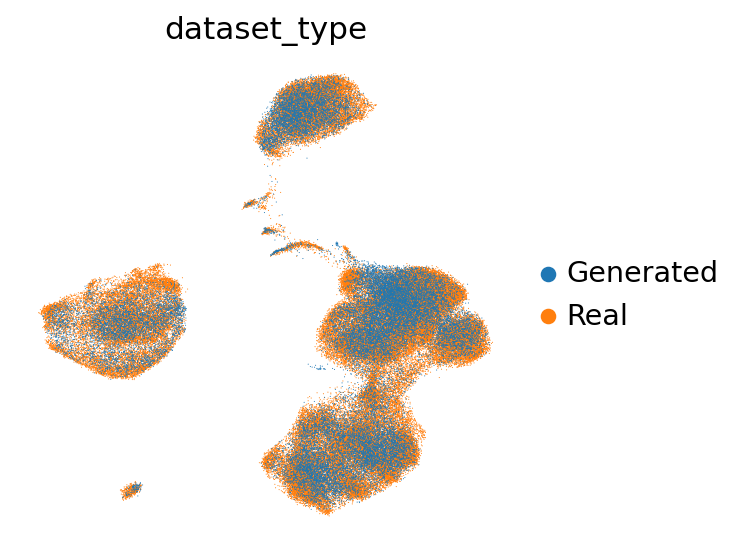

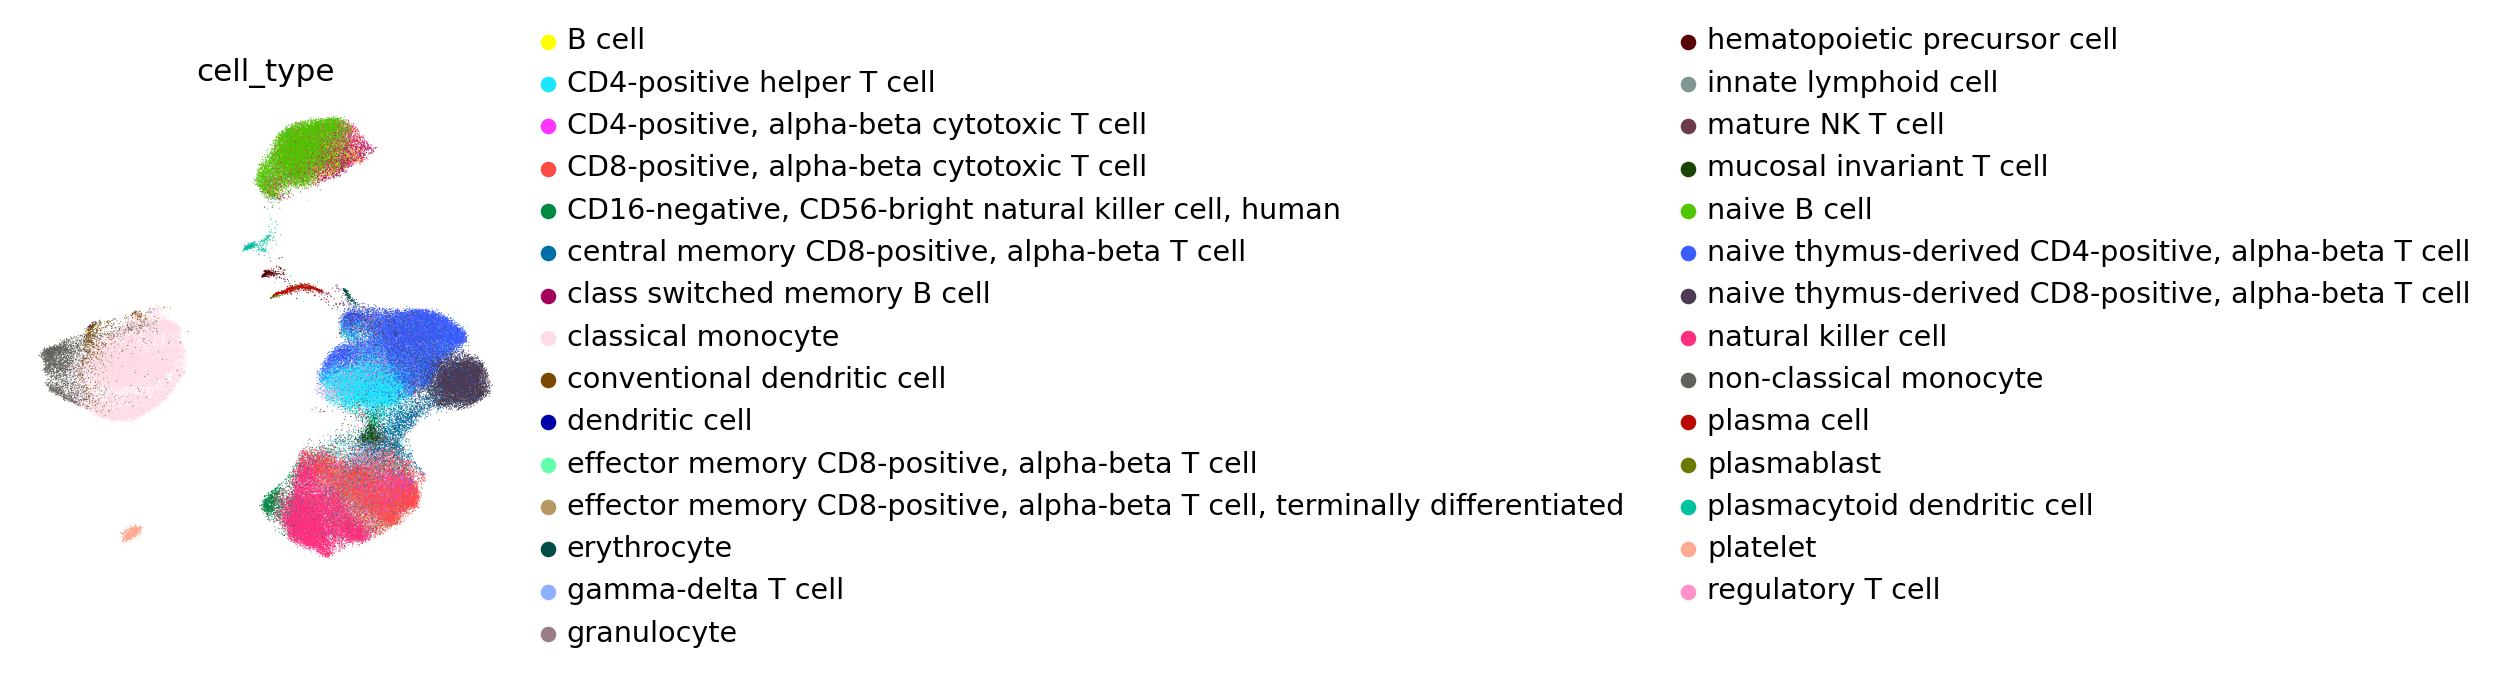

In [57]:
sc.pl.pca(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")